In [2]:
import tensorflow as tf
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet50
from keras.applications.resnet import decode_predictions
from keras.applications.resnet import preprocess_input
from keras.models import Model,Sequential
from keras.layers import Input,UpSampling2D,Flatten,BatchNormalization,Dense,Dropout,GlobalAveragePooling2D
from keras import optimizers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
IMAGE_SIZE = [224, 224]#Give dataset path
train = '/content/drive/MyDrive/train'
test = '/content/drive/MyDrive/test'

In [6]:
folders = glob('/content/drive/MyDrive/train/*')
print(len(folders))
num_classes = 20
nb_epochs = 10

20


In [7]:
# Fixed for our dataset
NUM_CLASSES = 20

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

In [8]:
resnet=ResNet50(include_top=False, weights='imagenet',input_shape=IMAGE_SIZE + [3])

94773248/94765736 [==============================] - 1s 0us/step


In [9]:
from keras.models import Model,Sequential
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 20)                40980     
Total params: 23,628,692
Trainable params: 40,980
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:

from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,)
model.compile(optimizer = opt, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [12]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        '/content/drive/MyDrive/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')


validation_generator = data_generator.flow_from_directory(
        '/content/drive/MyDrive/test',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 2000 images belonging to 20 classes.
Found 953 images belonging to 20 classes.


In [13]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


# Data Augmentation
test_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')==0.80):
      print('Akurasi mencapai 80%, proses training dihentikan!')
      self.model.stop_training = True

callbacks = myCallback()

In [15]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 25,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks = myCallback()

        
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
10/10 [==============================] - 643s 66s/step - loss: 3.4235 - accuracy: 0.1388 - val_loss: 2.3954 - val_accuracy: 0.3054
Epoch 2/25
10/10 [==============================] - 228s 23s/step - loss: 2.0108 - accuracy: 0.4073 - val_loss: 1.9782 - val_accuracy: 0.4365
Epoch 3/25
10/10 [==============================] - 193s 20s/step - loss: 1.6613 - accuracy: 0.5481 - val_loss: 1.7763 - val_accuracy: 0.4879
Epoch 4/25
10/10 [==============================] - 192s 20s/step - loss: 1.3890 - accuracy: 0.6110 - val_loss: 1.6360 - val_accuracy: 0.5467
Epoch 5/25
10/10 [==============================] - 190s 20s/step - loss: 1.2033 - accuracy: 0.6594 - val_loss: 1.4540 - val_accuracy: 0.6055
Epoch 6/25
10/10 [==============================] - 187s 20s/step - loss: 0.9992 - accuracy: 0.7350 - val_loss: 1.3539 - val_accuracy: 0.6359
Epoch 7/25
10/10 [==============================] - 187s 20s/step - loss: 0.9131 - accuracy: 0.7603 - val_loss: 1.2809 - val_accuracy: 0.6485
Epoch 

In [16]:
model.save("/content/drive/MyDrive/mymodelresnetV2.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
import numpy as np

from keras.preprocessing import image

In [18]:
from tensorflow.python.keras.models import load_model

In [19]:
test_image = image.load_img('/content/drive/MyDrive/test/batik-bali/0.jpg', target_size = (224, 224))

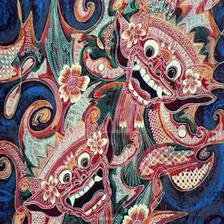

In [20]:
#show image
from IPython.display import display # to display images

img = Image.open('/content/drive/MyDrive/test/batik-bali/0.jpg')
display(img)

In [21]:
test_image = image.img_to_array(test_image)

In [22]:
test_image = np.expand_dims(test_image, axis = 0)

In [25]:
model = load_model('/content/drive/MyDrive/mymodelresnetV2.h5')

In [26]:
result = model.predict(test_image)

In [27]:
result = result[0]

In [28]:
classes = ['batik bali','batik betawi','batik celup','batik cendrawasih','batik ceplok', 'batik ciamis', 'batik garutan', 'batik gentongan', 'batik kawung', 'batik keraton', 'batik lasem', 'batik megamendung', 'batik parang', 'batik pekalongan', 'batik priangan', 'batik sekar', 'batik sidoluhur', 'batik sidomukti', 'batik sogan', 'batik tambal']

label_name = {classes[i]: result[i] for i in range(len(result))}
label_name

{'batik bali': 0.93036056,
 'batik betawi': 0.00011145124,
 'batik celup': 0.00014696419,
 'batik cendrawasih': 0.0050871097,
 'batik ceplok': 0.0012788633,
 'batik ciamis': 0.0036988766,
 'batik garutan': 2.3886955e-07,
 'batik gentongan': 9.161978e-05,
 'batik kawung': 0.001359288,
 'batik keraton': 0.011460285,
 'batik lasem': 0.00027469857,
 'batik megamendung': 0.00047257065,
 'batik parang': 0.02103852,
 'batik pekalongan': 0.02449154,
 'batik priangan': 2.078053e-06,
 'batik sekar': 2.1421525e-05,
 'batik sidoluhur': 5.104537e-05,
 'batik sidomukti': 7.087282e-06,
 'batik sogan': 4.544947e-05,
 'batik tambal': 2.8434118e-07}

In [29]:
output = max(label_name, key=label_name.get)
print(output)

batik bali


In [30]:
def predict(path_file):
  test_image = image.load_img(path_file, target_size = (224, 224))
  img = Image.open(path_file)
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  model = load_model('/content/drive/MyDrive/mymodelresnetV2.h5')
  result = model.predict(test_image)
  result = result[0]
  classes = ['batik bali','batik betawi','batik celup','batik cendrawasih','batik ceplok', 'batik ciamis', 'batik garutan', 'batik gentongan', 'batik kawung', 'batik keraton', 'batik lasem', 'batik megamendung', 'batik parang', 'batik pekalongan', 'batik priangan', 'batik sekar', 'batik sidoluhur', 'batik sidomukti', 'batik sogan', 'batik tambal']
  label_name = {classes[i]: result[i] for i in range(len(result))}
  label_name
  output = max(label_name, key=label_name.get)
  print(output)

In [31]:
predict('/content/drive/MyDrive/test/batik-bali/0.jpg')
predict('/content/drive/MyDrive/test/batik-bali/1.jpg')
predict('/content/drive/MyDrive/test/batik-bali/2.jpg')
predict('/content/drive/MyDrive/test/batik-bali/3.jpg')
predict('/content/drive/MyDrive/test/batik-bali/4.jpg')
predict('/content/drive/MyDrive/test/batik-bali/5.jpg')
predict('/content/drive/MyDrive/test/batik-bali/6.jpg')
predict('/content/drive/MyDrive/test/batik-bali/7.jpg')
predict('/content/drive/MyDrive/test/batik-bali/8.jpg')
predict('/content/drive/MyDrive/test/batik-bali/9.jpg')
predict('/content/drive/MyDrive/test/batik-bali/10.jpg')
predict('/content/drive/MyDrive/test/batik-bali/11.jpg')
predict('/content/drive/MyDrive/test/batik-bali/12.jpg')
predict('/content/drive/MyDrive/test/batik-bali/13.jpg')
predict('/content/drive/MyDrive/test/batik-bali/14.jpg')
predict('/content/drive/MyDrive/test/batik-bali/15.jpg')
predict('/content/drive/MyDrive/test/batik-bali/16.jpg')
predict('/content/drive/MyDrive/test/batik-bali/17.jpg')
predict('/content/drive/MyDrive/test/batik-bali/18.jpg')
predict('/content/drive/MyDrive/test/batik-bali/19.jpg')
predict('/content/drive/MyDrive/test/batik-bali/20.jpg')
predict('/content/drive/MyDrive/test/batik-bali/21.jpg')
predict('/content/drive/MyDrive/test/batik-bali/22.jpg')
predict('/content/drive/MyDrive/test/batik-bali/23.jpg')
predict('/content/drive/MyDrive/test/batik-bali/24.jpg')
predict('/content/drive/MyDrive/test/batik-bali/25.jpg')
predict('/content/drive/MyDrive/test/batik-bali/26.jpg')
predict('/content/drive/MyDrive/test/batik-bali/27.jpg')
predict('/content/drive/MyDrive/test/batik-bali/28.jpg')
predict('/content/drive/MyDrive/test/batik-bali/29.jpg')

batik bali
batik keraton
batik bali
batik bali
batik ciamis
batik priangan
batik ciamis
batik bali
batik betawi
batik pekalongan
batik garutan
batik kawung
batik bali
batik ceplok
batik ciamis
batik ciamis
batik ciamis
batik sidoluhur
batik garutan
batik gentongan
batik keraton
batik celup
batik ciamis
batik bali
batik ciamis
batik betawi
batik ciamis
batik betawi
batik bali
batik betawi


In [32]:
predict('/content/drive/MyDrive/test/batik-betawi/0.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/1.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/2.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/3.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/4.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/5.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/6.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/7.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/8.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/9.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/10.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/11.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/12.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/13.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/14.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/15.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/16.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/17.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/18.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/19.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/20.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/21.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/22.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/23.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/24.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/25.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/26.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/27.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/28.jpg')
predict('/content/drive/MyDrive/test/batik-betawi/29.jpg')

batik betawi
batik betawi
batik betawi
batik celup
batik betawi
batik celup
batik betawi
batik betawi
batik sekar
batik betawi
batik betawi
batik ciamis
batik betawi
batik sekar
batik ciamis
batik betawi
batik ceplok
batik betawi
batik celup
batik betawi
batik sekar
batik betawi
batik betawi
batik celup
batik garutan
batik betawi
batik betawi
batik ciamis
batik betawi
batik ceplok


In [33]:
predict('/content/drive/MyDrive/test/batik-celup/0.jpg')
predict('/content/drive/MyDrive/test/batik-celup/1.jpg')
predict('/content/drive/MyDrive/test/batik-celup/2.jpg')
predict('/content/drive/MyDrive/test/batik-celup/3.jpg')
predict('/content/drive/MyDrive/test/batik-celup/4.jpg')
predict('/content/drive/MyDrive/test/batik-celup/5.jpg')
predict('/content/drive/MyDrive/test/batik-celup/6.jpg')
predict('/content/drive/MyDrive/test/batik-celup/7.jpg')
predict('/content/drive/MyDrive/test/batik-celup/8.jpg')
predict('/content/drive/MyDrive/test/batik-celup/9.jpg')
predict('/content/drive/MyDrive/test/batik-celup/10.jpg')
predict('/content/drive/MyDrive/test/batik-celup/11.jpg')
predict('/content/drive/MyDrive/test/batik-celup/12.jpg')
predict('/content/drive/MyDrive/test/batik-celup/13.jpg')
predict('/content/drive/MyDrive/test/batik-celup/14.jpg')
predict('/content/drive/MyDrive/test/batik-celup/15.jpg')
predict('/content/drive/MyDrive/test/batik-celup/16.jpg')
predict('/content/drive/MyDrive/test/batik-celup/17.jpg')
predict('/content/drive/MyDrive/test/batik-celup/18.jpg')
predict('/content/drive/MyDrive/test/batik-celup/19.jpg')
predict('/content/drive/MyDrive/test/batik-celup/20.jpg')
predict('/content/drive/MyDrive/test/batik-celup/21.jpg')
predict('/content/drive/MyDrive/test/batik-celup/22.jpg')
predict('/content/drive/MyDrive/test/batik-celup/23.jpg')
predict('/content/drive/MyDrive/test/batik-celup/24.jpg')
predict('/content/drive/MyDrive/test/batik-celup/25.jpg')
predict('/content/drive/MyDrive/test/batik-celup/26.jpg')
predict('/content/drive/MyDrive/test/batik-celup/27.jpg')
predict('/content/drive/MyDrive/test/batik-celup/28.jpg')
predict('/content/drive/MyDrive/test/batik-celup/29.jpg')

batik celup
batik celup
batik celup
batik celup
batik celup
batik celup
batik celup
batik celup
batik ciamis
batik celup
batik celup
batik celup
batik celup
batik kawung
batik celup
batik celup
batik celup
batik celup
batik celup
batik celup
batik celup
batik ceplok
batik celup
batik celup
batik celup
batik celup
batik celup
batik celup
batik celup
batik celup


In [34]:
predict('/content/drive/MyDrive/test/batik-cendrawasih/0.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/1.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/2.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/3.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/4.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/5.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/6.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/7.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/8.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/9.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/10.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/11.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/12.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/13.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/14.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/15.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/16.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/17.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/18.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/19.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/20.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/21.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/22.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/23.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/24.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/25.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/26.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/27.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/28.jpg')
predict('/content/drive/MyDrive/test/batik-cendrawasih/29.jpg')

batik ciamis
batik betawi
batik ciamis
batik cendrawasih
batik sekar
batik parang
batik cendrawasih
batik keraton
batik cendrawasih
batik ceplok
batik celup
batik pekalongan
batik ciamis
batik cendrawasih
batik cendrawasih
batik cendrawasih
batik cendrawasih
batik sekar
batik betawi
batik ceplok
batik cendrawasih
batik pekalongan
batik celup
batik cendrawasih
batik bali
batik ceplok
batik ceplok
batik cendrawasih
batik cendrawasih
batik ceplok


In [35]:
predict('/content/drive/MyDrive/test/batik-ceplok/0.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/1.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/2.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/3.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/4.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/5.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/6.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/7.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/8.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/9.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/10.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/11.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/12.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/13.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/14.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/15.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/16.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/17.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/18.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/19.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/20.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/21.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/22.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/23.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/24.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/25.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/26.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/27.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/28.jpg')
predict('/content/drive/MyDrive/test/batik-ceplok/29.jpg')

batik sidoluhur
batik sidoluhur
batik ceplok
batik ceplok
batik ceplok
batik ceplok
batik ceplok
batik kawung
batik ceplok
batik ceplok
batik sidomukti
batik ceplok
batik ceplok
batik sidoluhur
batik ceplok
batik ceplok
batik ceplok
batik sidoluhur
batik ceplok
batik sidoluhur
batik ceplok
batik ceplok
batik ceplok
batik ceplok
batik ceplok
batik ceplok
batik ceplok
batik ceplok
batik ceplok
batik ceplok


In [36]:
predict('/content/drive/MyDrive/test/batik-ciamis/0.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/1.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/2.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/3.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/4.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/5.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/6.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/7.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/8.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/9.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/10.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/11.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/12.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/13.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/14.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/15.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/16.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/17.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/18.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/19.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/20.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/21.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/22.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/23.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/24.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/25.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/26.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/27.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/28.jpg')
predict('/content/drive/MyDrive/test/batik-ciamis/29.jpg')

batik pekalongan
batik ciamis
batik ciamis
batik ciamis
batik keraton
batik megamendung
batik ciamis
batik megamendung
batik ciamis
batik ciamis
batik ciamis
batik parang
batik ciamis
batik betawi
batik cendrawasih
batik betawi
batik megamendung
batik keraton
batik betawi
batik ciamis
batik ciamis
batik ciamis
batik celup
batik ciamis
batik megamendung
batik ciamis
batik ciamis
batik ciamis
batik kawung
batik ciamis


In [37]:
predict('/content/drive/MyDrive/test/batik-garutan/0.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/1.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/2.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/3.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/4.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/5.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/6.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/7.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/8.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/9.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/10.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/11.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/12.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/13.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/14.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/15.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/16.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/17.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/18.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/19.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/20.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/21.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/22.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/23.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/24.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/25.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/26.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/27.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/28.jpg')
predict('/content/drive/MyDrive/test/batik-garutan/29.jpg')

batik garutan
batik garutan
batik celup
batik betawi
batik kawung
batik garutan
batik garutan
batik megamendung
batik garutan
batik garutan
batik garutan
batik celup
batik celup
batik garutan
batik ciamis
batik sidoluhur
batik garutan
batik garutan
batik betawi
batik garutan
batik garutan
batik garutan
batik garutan
batik betawi
batik sekar
batik pekalongan
batik parang
batik garutan
batik celup
batik garutan


In [38]:
predict('/content/drive/MyDrive/test/batik-gentongan/0.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/1.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/2.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/3.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/4.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/5.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/6.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/7.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/8.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/9.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/10.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/11.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/12.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/13.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/14.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/15.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/16.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/17.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/18.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/19.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/20.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/21.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/22.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/23.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/24.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/25.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/26.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/27.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/28.jpg')
predict('/content/drive/MyDrive/test/batik-gentongan/29.jpg')

batik ciamis
batik ciamis
batik ceplok
batik gentongan
batik betawi
batik ceplok
batik ciamis
batik sidoluhur
batik ciamis
batik parang
batik megamendung
batik gentongan
batik ceplok
batik sekar
batik megamendung
batik sogan
batik sekar
batik keraton
batik ciamis
batik ceplok
batik ciamis
batik cendrawasih
batik ciamis
batik gentongan
batik celup
batik ceplok
batik ceplok
batik ciamis
batik ciamis
batik sekar


In [39]:
predict('/content/drive/MyDrive/test/batik-kawung/0.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/1.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/2.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/3.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/4.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/5.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/6.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/7.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/8.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/9.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/10.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/11.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/12.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/13.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/14.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/15.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/16.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/17.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/18.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/19.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/20.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/21.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/22.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/23.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/24.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/25.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/26.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/27.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/28.jpg')
predict('/content/drive/MyDrive/test/batik-kawung/29.jpg')

batik kawung
batik ceplok
batik kawung
batik ciamis
batik ceplok
batik ceplok
batik ceplok
batik kawung
batik ceplok
batik kawung
batik kawung
batik kawung
batik kawung
batik kawung
batik ciamis
batik kawung
batik kawung
batik kawung
batik ceplok
batik ceplok
batik kawung
batik kawung
batik ceplok
batik ciamis
batik kawung
batik ceplok
batik kawung
batik kawung
batik parang
batik kawung


In [40]:
predict('/content/drive/MyDrive/test/batik-keraton/0.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/1.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/2.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/3.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/4.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/5.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/6.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/7.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/8.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/9.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/10.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/11.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/12.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/13.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/14.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/15.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/16.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/17.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/18.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/19.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/20.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/21.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/22.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/23.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/24.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/25.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/26.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/27.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/28.jpg')
predict('/content/drive/MyDrive/test/batik-keraton/29.jpg')

batik ciamis
batik keraton
batik keraton
batik keraton
batik parang
batik parang
batik cendrawasih
batik sekar
batik kawung
batik parang
batik sidoluhur
batik keraton
batik keraton
batik keraton
batik keraton
batik priangan
batik keraton
batik garutan
batik pekalongan
batik parang
batik pekalongan
batik ciamis
batik parang
batik keraton
batik ciamis
batik ciamis
batik pekalongan
batik ceplok
batik ciamis
batik parang


In [41]:
predict('/content/drive/MyDrive/test/batik-lasem/0.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/1.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/2.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/3.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/4.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/5.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/6.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/7.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/8.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/9.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/10.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/11.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/12.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/13.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/14.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/15.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/16.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/17.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/18.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/19.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/20.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/21.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/22.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/23.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/24.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/25.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/26.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/27.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/28.jpg')
predict('/content/drive/MyDrive/test/batik-lasem/29.jpg')

batik ciamis
batik pekalongan
batik pekalongan
batik ciamis
batik lasem
batik ciamis
batik keraton
batik keraton
batik lasem
batik cendrawasih
batik ciamis
batik ciamis
batik pekalongan
batik ciamis
batik lasem
batik ciamis
batik keraton
batik sidoluhur
batik lasem
batik keraton
batik lasem
batik lasem
batik lasem
batik ciamis
batik ciamis
batik ciamis
batik betawi
batik ciamis
batik lasem
batik ciamis


In [42]:
predict('/content/drive/MyDrive/test/batik-megamendung/0.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/1.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/2.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/3.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/4.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/5.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/6.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/7.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/8.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/9.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/10.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/11.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/12.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/13.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/14.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/15.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/16.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/17.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/18.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/19.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/20.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/21.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/22.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/23.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/24.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/25.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/26.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/27.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/28.jpg')
predict('/content/drive/MyDrive/test/batik-megamendung/29.jpg')

batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung
batik megamendung


In [43]:
predict('/content/drive/MyDrive/test/batik-parang/0.jpg')
predict('/content/drive/MyDrive/test/batik-parang/1.jpg')
predict('/content/drive/MyDrive/test/batik-parang/2.jpg')
predict('/content/drive/MyDrive/test/batik-parang/3.jpg')
predict('/content/drive/MyDrive/test/batik-parang/4.jpg')
predict('/content/drive/MyDrive/test/batik-parang/5.jpg')
predict('/content/drive/MyDrive/test/batik-parang/6.jpg')
predict('/content/drive/MyDrive/test/batik-parang/7.jpg')
predict('/content/drive/MyDrive/test/batik-parang/8.jpg')
predict('/content/drive/MyDrive/test/batik-parang/9.jpg')
predict('/content/drive/MyDrive/test/batik-parang/10.jpg')
predict('/content/drive/MyDrive/test/batik-parang/11.jpg')
predict('/content/drive/MyDrive/test/batik-parang/12.jpg')
predict('/content/drive/MyDrive/test/batik-parang/13.jpg')
predict('/content/drive/MyDrive/test/batik-parang/14.jpg')
predict('/content/drive/MyDrive/test/batik-parang/15.jpg')
predict('/content/drive/MyDrive/test/batik-parang/16.jpg')
predict('/content/drive/MyDrive/test/batik-parang/17.jpg')
predict('/content/drive/MyDrive/test/batik-parang/18.jpg')
predict('/content/drive/MyDrive/test/batik-parang/19.jpg')
predict('/content/drive/MyDrive/test/batik-parang/20.jpg')
predict('/content/drive/MyDrive/test/batik-parang/21.jpg')
predict('/content/drive/MyDrive/test/batik-parang/22.jpg')
predict('/content/drive/MyDrive/test/batik-parang/23.jpg')
predict('/content/drive/MyDrive/test/batik-parang/24.jpg')
predict('/content/drive/MyDrive/test/batik-parang/25.jpg')
predict('/content/drive/MyDrive/test/batik-parang/26.jpg')
predict('/content/drive/MyDrive/test/batik-parang/27.jpg')
predict('/content/drive/MyDrive/test/batik-parang/28.jpg')
predict('/content/drive/MyDrive/test/batik-parang/29.jpg')

batik ciamis
batik kawung
batik parang
batik parang
batik parang
batik sekar
batik ciamis
batik parang
batik betawi
batik ceplok
batik pekalongan
batik parang
batik parang
batik ciamis
batik parang
batik ceplok
batik megamendung
batik parang
batik garutan
batik megamendung
batik betawi
batik parang
batik parang
batik parang
batik ciamis
batik parang
batik garutan
batik parang
batik ciamis
batik ceplok


In [44]:
predict('/content/drive/MyDrive/test/batik-pekalongan/0.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/1.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/2.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/3.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/4.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/5.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/6.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/7.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/8.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/9.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/10.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/11.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/12.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/13.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/14.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/15.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/16.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/17.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/18.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/19.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/20.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/21.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/22.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/23.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/24.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/25.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/26.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/27.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/28.jpg')
predict('/content/drive/MyDrive/test/batik-pekalongan/29.jpg')

batik ciamis
batik keraton
batik pekalongan
batik ciamis
batik keraton
batik megamendung
batik ceplok
batik pekalongan
batik pekalongan
batik pekalongan
batik garutan
batik ciamis
batik pekalongan
batik ciamis
batik pekalongan
batik pekalongan
batik ciamis
batik ciamis
batik cendrawasih
batik pekalongan
batik pekalongan
batik pekalongan
batik pekalongan
batik ciamis
batik pekalongan
batik ciamis
batik sekar
batik pekalongan
batik celup
batik priangan


In [45]:
predict('/content/drive/MyDrive/test/batik-priangan/0.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/1.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/2.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/3.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/4.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/5.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/6.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/7.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/8.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/9.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/10.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/11.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/12.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/13.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/14.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/15.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/16.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/17.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/18.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/19.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/20.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/21.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/22.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/23.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/24.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/25.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/26.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/27.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/28.jpg')
predict('/content/drive/MyDrive/test/batik-priangan/29.jpg')

batik sekar
batik betawi
batik ceplok
batik celup
batik sekar
batik priangan
batik priangan
batik betawi
batik parang
batik sekar
batik ciamis
batik priangan
batik ceplok
batik tambal
batik celup
batik sekar
batik ciamis
batik priangan
batik betawi
batik betawi
batik keraton
batik celup
batik ciamis
batik celup
batik keraton
batik pekalongan
batik pekalongan
batik celup
batik ceplok
batik priangan


In [46]:
predict('/content/drive/MyDrive/test/batik-sekar/0.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/1.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/2.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/3.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/4.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/5.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/6.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/7.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/8.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/9.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/10.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/11.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/12.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/13.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/14.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/15.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/16.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/17.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/18.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/19.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/20.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/21.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/22.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/23.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/24.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/25.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/26.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/27.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/28.jpg')
predict('/content/drive/MyDrive/test/batik-sekar/29.jpg')

batik sekar
batik sekar
batik sidoluhur
batik ceplok
batik ceplok
batik sekar
batik sekar
batik sogan
batik ceplok
batik ceplok
batik ceplok
batik sekar
batik sidoluhur
batik ceplok
batik ceplok
batik sekar
batik ceplok
batik sekar
batik ciamis
batik sekar
batik sekar
batik cendrawasih
batik cendrawasih
batik ceplok
batik ceplok
batik sekar
batik sogan
batik celup
batik sekar
batik sekar


In [47]:
predict('/content/drive/MyDrive/test/batik-sidoluhur/0.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/1.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/2.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/3.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/4.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/5.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/6.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/7.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/8.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/9.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/10.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/11.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/12.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/13.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/14.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/15.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/16.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/17.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/18.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/19.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/20.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/21.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/22.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/23.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/24.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/25.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/26.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/27.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/28.jpg')
predict('/content/drive/MyDrive/test/batik-sidoluhur/29.jpg')

batik sidoluhur
batik sidoluhur
batik sidoluhur
batik sidoluhur
batik sidoluhur
batik ceplok
batik sidoluhur
batik sidoluhur
batik sidoluhur
batik sidoluhur
batik sidoluhur
batik sidoluhur
batik sidoluhur
batik sidoluhur
batik sidoluhur
batik sidoluhur
batik sekar
batik pekalongan
batik sidoluhur
batik sidoluhur
batik ceplok
batik ceplok
batik sidoluhur
batik sidoluhur
batik sidoluhur
batik celup
batik sidoluhur
batik ceplok
batik sidoluhur
batik garutan


In [48]:
predict('/content/drive/MyDrive/test/batik-sidomukti/0.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/1.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/2.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/3.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/4.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/5.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/6.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/7.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/8.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/9.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/10.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/11.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/12.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/13.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/14.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/15.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/16.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/17.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/18.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/19.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/20.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/21.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/22.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/23.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/24.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/25.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/26.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/27.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/28.jpg')
predict('/content/drive/MyDrive/test/batik-sidomukti/29.jpg')

batik betawi
batik sidoluhur
batik betawi
batik sekar
batik sekar
batik celup
batik sidoluhur
batik sidomukti
batik sidoluhur
batik parang
batik sidomukti
batik ceplok
batik betawi
batik sidomukti
batik ceplok
batik ceplok
batik ciamis
batik ceplok
batik ceplok
batik ciamis
batik pekalongan
batik betawi
batik pekalongan
batik sekar
batik ceplok
batik ceplok
batik celup
batik sogan
batik celup
batik sogan


In [49]:
predict('/content/drive/MyDrive/test/batik-sogan/0.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/1.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/2.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/3.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/4.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/5.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/6.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/7.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/8.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/9.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/10.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/11.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/12.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/13.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/14.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/15.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/16.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/17.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/18.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/19.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/20.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/21.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/22.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/23.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/24.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/25.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/26.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/27.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/28.jpg')
predict('/content/drive/MyDrive/test/batik-sogan/29.jpg')

batik sogan
batik sogan
batik ciamis
batik ceplok
batik pekalongan
batik betawi
batik ciamis
batik parang
batik sidoluhur
batik priangan
batik keraton
batik sekar
batik ciamis
batik sogan
batik pekalongan
batik sogan
batik sekar
batik ceplok
batik keraton
batik sogan
batik sekar
batik ciamis
batik sogan
batik ceplok
batik sogan
batik sogan
batik ceplok
batik ceplok
batik sogan
batik ceplok


In [50]:
predict('/content/drive/MyDrive/test/batik-tambal/0.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/1.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/2.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/3.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/4.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/5.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/6.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/7.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/8.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/9.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/10.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/11.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/12.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/13.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/14.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/15.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/16.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/17.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/18.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/19.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/20.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/21.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/22.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/23.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/24.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/25.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/26.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/27.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/28.jpg')
predict('/content/drive/MyDrive/test/batik-tambal/29.jpg')

batik sidoluhur
batik keraton
batik celup
batik ceplok
batik celup
batik ceplok
batik cendrawasih
batik parang
batik tambal
batik sidoluhur
batik ceplok
batik tambal
batik celup
batik tambal
batik tambal
batik ceplok
batik sekar
batik betawi
batik tambal
batik tambal
batik sidoluhur
batik tambal
batik betawi
batik ceplok
batik sogan
batik garutan
batik tambal
batik betawi
batik tambal
batik sidoluhur
